In [1]:
# ==============================================================================
# PROYECTO FINAL: TOPOLOGÍA COMPUTACIONAL
# ==============================================================================
# Autoras: María Sáez Díaz y Jessica Xianping Ren
# Descripción: Implementación de complejos simpliciales, homología, 
# filtraciones (Rips/Alpha) y persistencia topológica.
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt
import math
from itertools import combinations
from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d  # Rips/Alpha/Voronoi

# Configuración de gráficos
plt.style.use('seaborn-v0_8-whitegrid')

print("1. Librerías cargadas correctamente.")

def smith_normal_form_z2(matrix):
    """
    Calcula el rango de una matriz sobre Z2 (coeficientes 0 y 1).
    Equivalente a la Forma Normal de Smith para cuerpos.
    """
    if matrix.size == 0:
        return 0
    M = matrix.copy().astype(int)
    rows, cols = M.shape
    pivot_row = 0
    pivot_col = 0
    rank = 0
    
    while pivot_row < rows and pivot_col < cols:
        pivot_indices = np.where(M[pivot_row:, pivot_col] == 1)[0]
        if pivot_indices.size == 0:
            pivot_col += 1
            continue
            
        current_pivot_row = pivot_indices[0] + pivot_row
        if current_pivot_row != pivot_row:
            M[[pivot_row, current_pivot_row]] = M[[current_pivot_row, pivot_row]]
            
        for i in range(pivot_row + 1, rows):
            if M[i, pivot_col] == 1:
                M[i, :] = (M[i, :] + M[pivot_row, :]) % 2
                
        for j in range(pivot_col + 1, cols):
            if M[pivot_row, j] == 1:
                M[:, j] = (M[:, j] + M[:, pivot_col]) % 2

        pivot_row += 1
        pivot_col += 1
        rank += 1
    return rank


1. Librerías cargadas correctamente.


In [3]:
class SimplicialComplex:
    """
    Clase principal para manejar Complejos Simpliciales.
    Incluye: Betti, Euler, Conexidad, Estrella, Link y Filtraciones.
    """
    def __init__(self):
        self._simplices = set()
        self._simplex_values = {}  # {simplex: float_value}

    def add_simplex(self, simplex, value=0.0):
        """Añade un símplice y asegura clausura (añade todas sus caras)."""
        simplex = tuple(sorted(simplex))
        if not simplex:
            return

        n = len(simplex)
        for r in range(1, n + 1):
            for face in combinations(simplex, r):
                face = tuple(sorted(face))
                self._simplices.add(face)
                if face not in self._simplex_values or value < self._simplex_values[face]:
                    self._simplex_values[face] = float(value)

    def insert(self, simplices_input):
        """Interfaz para insertar listas de símplices [(s, val), ...] o [s, ...]."""
        for item in simplices_input:
            if isinstance(item, tuple) and len(item) == 2 and isinstance(item[0], (tuple, list, np.ndarray)):
                self.add_simplex(item[0], item[1])
            else:
                self.add_simplex(item, 0.0)

    def filtration(self, t):
        """Recupera el subcomplejo formado por símplices con valor <= t."""
        sub = SimplicialComplex()
        sub.insert([(s, v) for s, v in self._simplex_values.items() if v <= t])
        return sub
    
    # --- Propiedades geométricas ---
    @property
    def dimension(self):
        return max(len(f) for f in self._simplices) - 1 if self._simplices else -1

    def n_faces(self, n):
        """Devuelve las caras de dimensión n."""
        return [f for f in self._simplices if len(f) - 1 == n]
    
    @property
    def face_set(self):
        return self._simplices

    def star(self, simplex):
        """Calcula la estrella de un símplice."""
        target = set(simplex)
        return [s for s in self._simplices if target.issubset(s)]

    def link(self, simplex):
        """Calcula el link de un símplice."""
        target = set(simplex)
        star = self.star(simplex)
        return [tuple(sorted(set(s) - target)) for s in star if set(s) - target]

    def euler_characteristic(self):
        """Calcula la característica de Euler."""
        return sum((-1)**(len(f) - 1) for f in self._simplices)

    def connected_components(self):
        """Componentes conexas (Betti 0) vía Union-Find."""
        vertices = sorted(list(set(v for s in self._simplices for v in s)))
        if not vertices:
            return 0
        parent = {v: v for v in vertices}
        def find(v):
            if parent[v] != v:
                parent[v] = find(parent[v])
            return parent[v]
        def union(u, v):
            root_u, root_v = find(u), find(v)
            if root_u != root_v:
                parent[root_u] = root_v
        for edge in self.n_faces(1):
            union(edge[0], edge[1])
        return len(set(find(v) for v in vertices))

    # --- Homología ---
    def boundary_matrix(self, p):
        """Calcula matriz borde M_p en Z2."""
        if p <= 0:
            return np.zeros((0, 0))
        row_faces = sorted(self.n_faces(p - 1))
        col_faces = sorted(self.n_faces(p))
        if not col_faces:
            return np.zeros((0, 0))
        if not row_faces:
            return np.zeros((0, len(col_faces)))

        idx_map = {f: i for i, f in enumerate(row_faces)}
        M = np.zeros((len(row_faces), len(col_faces)), dtype=int)
        for j, sigma in enumerate(col_faces):
            for face in combinations(sigma, p):
                face = tuple(sorted(face))
                if face in idx_map:
                    M[idx_map[face], j] = 1
        return M

    def betti_numbers(self):
        """Calcula los números de Betti {dim: cantidad}."""
        dim = self.dimension
        bettis = {}
        ranks = {}
        for p in range(1, dim + 2):
            ranks[p] = smith_normal_form_z2(self.boundary_matrix(p))
        
        bettis[0] = len(self.n_faces(0)) - ranks.get(1, 0)
        for p in range(1, dim + 1):
            bettis[p] = len(self.n_faces(p)) - ranks.get(p, 0) - ranks.get(p + 1, 0)
        return bettis

print("2. Clase SimplicialComplex cargada.")


2. Clase SimplicialComplex cargada.


In [5]:
def vietoris_rips_filtration(points, max_epsilon, max_dim=2):
    """
    Construye filtración Vietoris-Rips manualmente (distancias + cliques).
    """
    num_points = len(points)
    simplices = [] 
    
    # 1. Vértices
    for i in range(num_points):
        simplices.append(((i,), 0.0))
        
    # 2. Aristas
    edges = []
    for i in range(num_points):
        for j in range(i + 1, num_points):
            dist = math.sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(points[i], points[j])))
            if dist <= max_epsilon:
                edge = tuple(sorted((i, j)))
                simplices.append((edge, dist))
                edges.append((edge, dist))

    # 3. Triángulos
    if max_dim >= 2:
        edge_dict = {e[0]: e[1] for e in edges}
        for i in range(num_points):
            for j in range(i + 1, num_points):
                for k in range(j + 1, num_points):
                    if (i, j) in edge_dict and (j, k) in edge_dict and (i, k) in edge_dict:
                        birth = max(edge_dict[(i, j)], edge_dict[(j, k)], edge_dict[(i, k)])
                        if birth <= max_epsilon:
                            simplices.append(((i, j, k), birth))

    sc = SimplicialComplex()
    sc.insert(simplices)
    return sc

def alpha_complex_filtration(points):
    """
    Calcula filtración de Alfa Complejos usando Delaunay.
    """
    points = np.array(points)
    tri = Delaunay(points)
    complex_data = []

    def circumradius(simp_indices):
        pts = points[list(simp_indices)]
        if len(pts) == 2:
            return np.linalg.norm(pts[0] - pts[1]) / 2.0
        elif len(pts) == 3:
            a, b, c = pts[0], pts[1], pts[2]
            la, lb, lc = np.linalg.norm(b - c), np.linalg.norm(a - c), np.linalg.norm(a - b)
            p = (la + lb + lc) / 2
            area_term = p * (p - la) * (p - lb) * (p - lc)
            area = np.sqrt(area_term) if area_term > 0 else 0
            return (la * lb * lc) / (4 * area) if area > 0 else float('inf')
        return 0.0

    # Vértices
    for i in range(len(points)):
        complex_data.append(((i,), 0.0))

    # Triángulos y aristas de Delaunay
    for simplex in tri.simplices:
        complex_data.append((tuple(sorted(simplex)), circumradius(simplex)))
        for i in range(3):
            edge = tuple(sorted([simplex[i], simplex[(i + 1) % 3]]))
            complex_data.append((edge, circumradius(edge)))
            
    sc = SimplicialComplex()
    sc.insert(complex_data)
    return sc

print("3. Funciones de filtración (Rips y Alpha) cargadas.")


3. Funciones de filtración (Rips y Alpha) cargadas.


In [7]:
def compute_persistence_matrix(complex_obj):
    """
    Calcula intervalos de persistencia usando Reducción de Matriz Borde.
    Retorna: {dimensión: [(nacimiento, muerte), ...]}.
    """
    filtration = sorted(
        complex_obj._simplex_values.items(),
        key=lambda x: (x[1], len(x[0]))
    )
    n = len(filtration)
    idx_to_simplex = {i: s for i, s in enumerate(filtration)}
    simplex_to_idx = {s[0]: i for i, s in enumerate(filtration)}
    
    # Construir Matriz Borde (dispersa)
    columns = {}
    for j in range(n):
        simp, val = idx_to_simplex[j]
        dim = len(simp) - 1
        col = set()
        if dim > 0:
            for face in combinations(simp, dim):
                if face in simplex_to_idx:
                    col.add(simplex_to_idx[face])
        columns[j] = col

    # Reducción Gaussiana Z2
    pivot_to_col = {} 
    for j in range(n):
        while columns[j]:
            low_j = max(columns[j])
            if low_j in pivot_to_col:
                k = pivot_to_col[low_j]
                columns[j] = columns[j].symmetric_difference(columns[k])
            else:
                pivot_to_col[low_j] = j
                break
                
    # Extraer diagrama
    diagram = {}
    deaths = set(pivot_to_col.values())
    births_with_death = set(pivot_to_col.keys())
    
    for i, j in pivot_to_col.items():
        birth = idx_to_simplex[i][1]
        death = idx_to_simplex[j][1]
        dim = len(idx_to_simplex[i][0]) - 1
        if death > birth:
            diagram.setdefault(dim, []).append((birth, death))
        
    for i in range(n):
        if i not in births_with_death and i not in deaths:
            birth = idx_to_simplex[i][1]
            dim = len(idx_to_simplex[i][0]) - 1
            diagram.setdefault(dim, []).append((birth, float('inf')))
            
    return diagram

print("4. Algoritmo de Persistencia cargado.")


4. Algoritmo de Persistencia cargado.


In [9]:
def plot_barcode(diagram, title="Código de Barras"):
    fig, ax = plt.subplots(figsize=(10, 4))
    y = 0
    colors = {0: 'blue', 1: 'red'}
    valid_dims = [d for d in diagram.keys() if d < 2]  # Solo H0 y H1
    
    all_vals = [d for dim in valid_dims for b, d in diagram[dim] if d != float('inf')]
    max_val = max(all_vals) if all_vals else 1.0
    inf_limit = max_val * 1.2

    for dim in sorted(valid_dims):
        bars = sorted(
            diagram[dim],
            key=lambda x: (x[1] if x[1] != float('inf') else 999) - x[0],
            reverse=True
        )
        for b, d in bars:
            end = d if d != float('inf') else inf_limit
            ax.plot([b, end], [y, y], color=colors.get(dim, 'k'), lw=3)
            if d == float('inf'):
                ax.text(end, y, r' $\infty$', va='center')
            y += 1
        y += 2
        
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xlabel("Filtración")
    plt.show()

def plot_persistence_diagram(diagram, title="Diagrama de Persistencia"):
    fig, ax = plt.subplots(figsize=(5, 5))
    valid_dims = [d for d in diagram.keys() if d < 2]
    all_vals = [d for dim in valid_dims for b, d in diagram[dim] if d != float('inf')]
    max_val = max(all_vals) if all_vals else 1.0
    inf_limit = max_val * 1.1
    
    ax.plot([0, inf_limit], [0, inf_limit], 'k--', alpha=0.5)
    colors = {0: 'blue', 1: 'red'}
    
    for dim in sorted(valid_dims):
        pairs = diagram[dim]
        births = [p[0] for p in pairs]
        deaths = [p[1] if p[1] != float('inf') else inf_limit for p in pairs]
        ax.scatter(births, deaths, color=colors.get(dim, 'k'), label=f'H{dim}', alpha=0.6)
        
    ax.set_title(title)
    ax.set_xlabel("Nacimiento")
    ax.set_ylabel("Muerte")
    ax.legend()
    plt.show()

def visualize_incremental_step(ax, simplices_so_far, new_simplex, points, title):
    for simplex in simplices_so_far:
        if simplex == new_simplex:
            continue
        pts = points[list(simplex)]
        if len(simplex) == 1:
            ax.plot(pts[0][0], pts[0][1], 'bo', markersize=6, alpha=0.3)
        elif len(simplex) == 2:
            ax.plot(pts[:, 0], pts[:, 1], 'b-', alpha=0.2)
        elif len(simplex) == 3:
            ax.fill(pts[:, 0], pts[:, 1], 'cyan', alpha=0.1)

    pts_new = points[list(new_simplex)]
    if len(new_simplex) == 1:
        ax.plot(pts_new[0][0], pts_new[0][1], 'ro', markersize=10)
    elif len(new_simplex) == 2:
        ax.plot(pts_new[:, 0], pts_new[:, 1], 'r-', linewidth=2.5)
    elif len(new_simplex) == 3:
        ax.fill(pts_new[:, 0], pts_new[:, 1], 'red', alpha=0.4)
    ax.set_title(title, fontsize=9)
    ax.axis('off')

def run_visual_incremental(sc, points):
    ordered = sorted(sc._simplex_values.items(), key=lambda x: (x[1], len(x[0])))
    n = min(len(ordered), 16)
    cols = 4
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    axes = axes.flatten()
    K_curr = SimplicialComplex()
    hist = []
    
    print("\n--- Visualización Algoritmo Incremental ---")
    for i in range(n):
        simplex, val = ordered[i]
        K_curr.add_simplex(simplex, val)
        hist.append(simplex)
        bettis = K_curr.betti_numbers()
        if i < len(axes):
            visualize_incremental_step(
                axes[i], hist, simplex, points,
                f"Paso {i+1}: {simplex}\nB: {bettis}"
            )
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

print("5. Visualización cargada.")


5. Visualización cargada.


In [11]:
def get_torus_minimal():
    return [
        (0,1,2),(0,1,5),(0,2,4),(0,3,4),(0,3,6),(0,5,6),
        (1,2,6),(1,3,4),(1,3,5),(1,4,6),(2,3,5),(2,3,6),
        (2,4,5),(3,4,6),(4,5,6)
    ]

def get_klein_bottle():
    return [
        (0,1,4),(1,2,5),(2,0,3),(0,4,3),(1,5,4),(2,3,5),
        (3,4,7),(4,5,8),(5,3,6),(3,7,6),(4,8,7),(5,6,8),
        (6,7,2),(7,8,0),(8,6,1),(6,2,5),(7,0,3),(8,1,4)
    ]

def get_projective_plane():
    return [tuple(v - 1 for v in s) for s in [
        (1,2,6),(1,2,5),(1,3,4),(1,3,6),(1,4,5),(2,3,5),
        (2,3,6),(2,4,5),(2,4,6),(3,4,6),(3,4,5),(3,5,6),
        (4,5,6),(1,2,3),(1,2,4),(1,3,5),(1,4,6),(1,5,6),
        (2,3,4),(2,5,6)
    ]]

def get_dunce_hat():
    return [(0,1,2), (0,1,3), (0,2,3), (1,2,3)]

def get_tetrahedron():
    return [(0,1,2,3)]

def get_transparency_4_complex():
    return [(0,1,2),(1,2,3),(2,3,0)]

print("6. Generadores de superficies listos.")


6. Generadores de superficies listos.


=== 1. NÚMEROS DE BETTI DE SUPERFICIES ===
  > Tetraedro            | Betti: {0: 1, 1: 0, 2: 0, 3: 0}
  > Toro (7 vért.)       | Betti: {0: 1, 1: 1, 2: 1}
  > Botella Klein        | Betti: {0: 1, 1: 1, 2: 0}
  > Plano Proyectivo     | Betti: {0: 1, 1: 0, 2: 10}
  > Sombrero Asno        | Betti: {0: 1, 1: 0, 2: 1}
  > Transparencia 4      | Betti: {0: 1, 1: 0, 2: 0}

=== 2. PERSISTENCIA: NUBE DE PUNTOS ===
  > Rips...


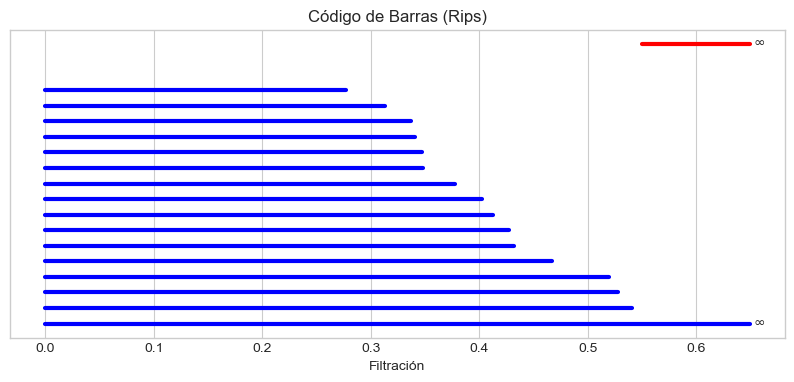

  > Alfa...


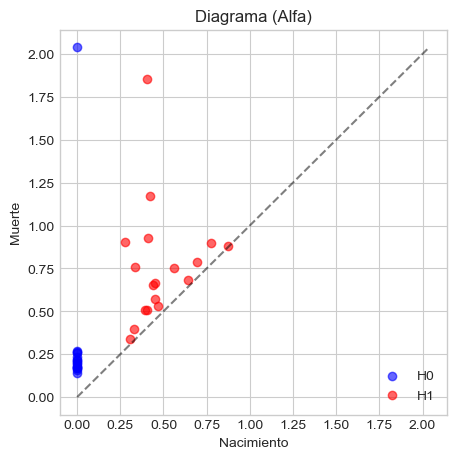


=== 3. VISUALIZACIÓN INCREMENTAL ===

--- Visualización Algoritmo Incremental ---


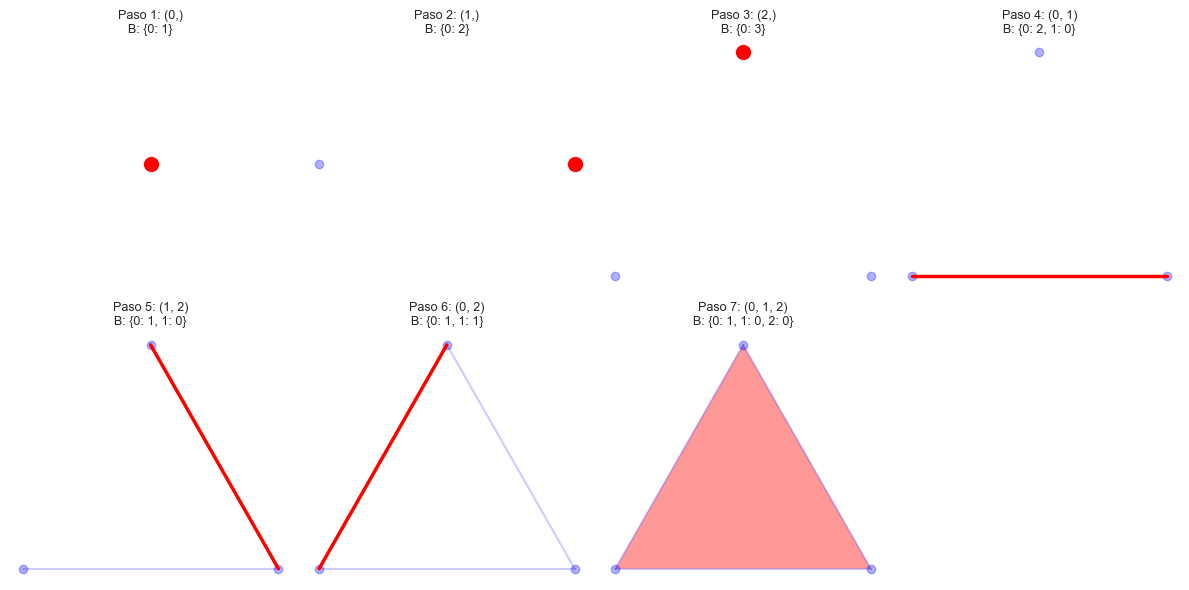

In [13]:
# ==============================================================================
# EJECUCIÓN Y VALIDACIÓN
# ==============================================================================

print("=== 1. NÚMEROS DE BETTI DE SUPERFICIES ===")
surfaces = {
    "Tetraedro": get_tetrahedron(),
    "Toro (7 vért.)": get_torus_minimal(),
    "Botella Klein": get_klein_bottle(),
    "Plano Proyectivo": get_projective_plane(),
    "Sombrero Asno": get_dunce_hat(),
    "Transparencia 4": get_transparency_4_complex()
}

for name, data in surfaces.items():
    sc = SimplicialComplex()
    sc.insert(data)
    print(f"  > {name:<20} | Betti: {sc.betti_numbers()}")

print("\n=== 2. PERSISTENCIA: NUBE DE PUNTOS ===")
np.random.seed(42)
t = np.linspace(0, 2 * np.pi, 16, endpoint=False)
points = np.column_stack([np.cos(t), np.sin(t)]) + np.random.normal(0, 0.08, (16, 2))

print("  > Rips...")
sc_rips = vietoris_rips_filtration(points, 1.5, 2)
diag_rips = compute_persistence_matrix(sc_rips)
plot_barcode(diag_rips, "Código de Barras (Rips)")

print("  > Alfa...")
sc_alpha = alpha_complex_filtration(points)
diag_alpha = compute_persistence_matrix(sc_alpha)
plot_persistence_diagram(diag_alpha, "Diagrama (Alfa)")

print("\n=== 3. VISUALIZACIÓN INCREMENTAL ===")
tri_points = np.array([[0.1, 0.1], [0.9, 0.1], [0.5, 0.8]])
sc_demo = SimplicialComplex()
sc_demo.insert([
    ((0,), 1), ((1,), 2), ((2,), 3),
    ((0,1), 4), ((1,2), 5), ((0,2), 6),
    ((0,1,2), 7)
])
run_visual_incremental(sc_demo, tri_points)


=== PRUEBA VISUAL: VORONOI Y ALFA ===
1. Generando Diagrama de Voronoi...


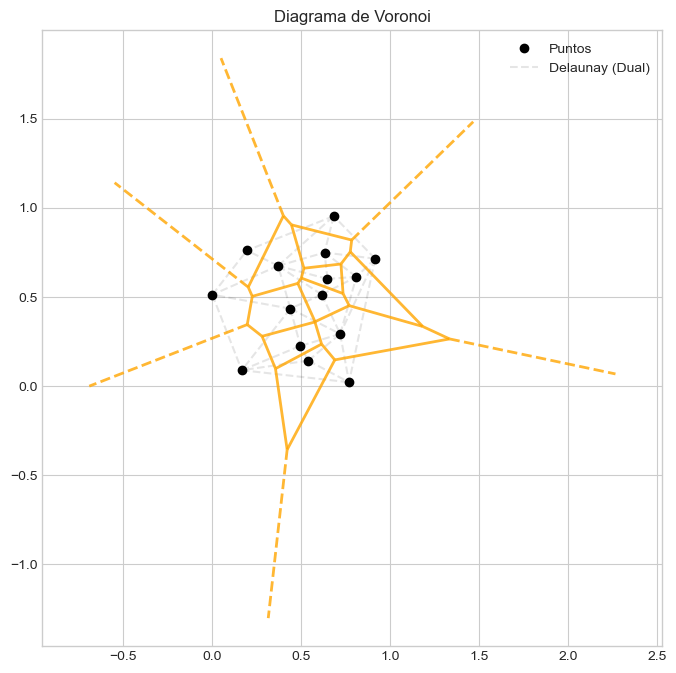

2. Generando Alfa Complejo (alpha=0.15 - Poca conectividad)...


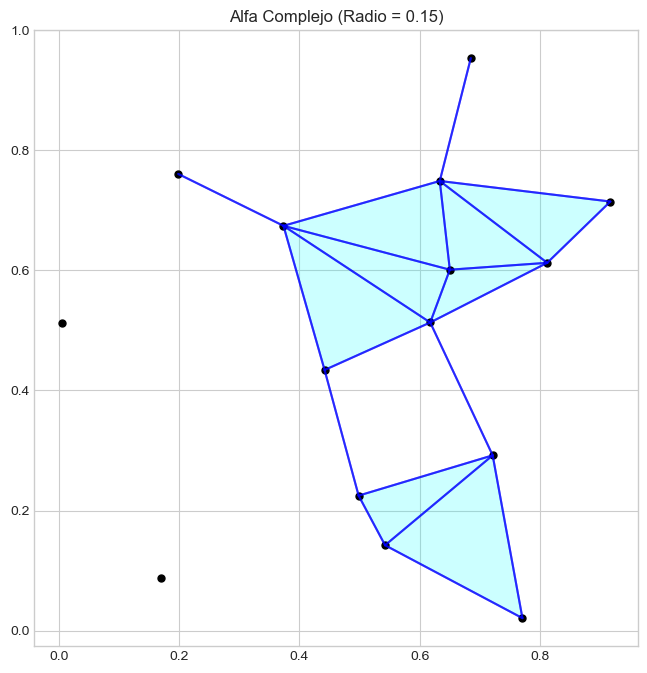

3. Generando Alfa Complejo (alpha=0.3 - Aparecen ciclos)...


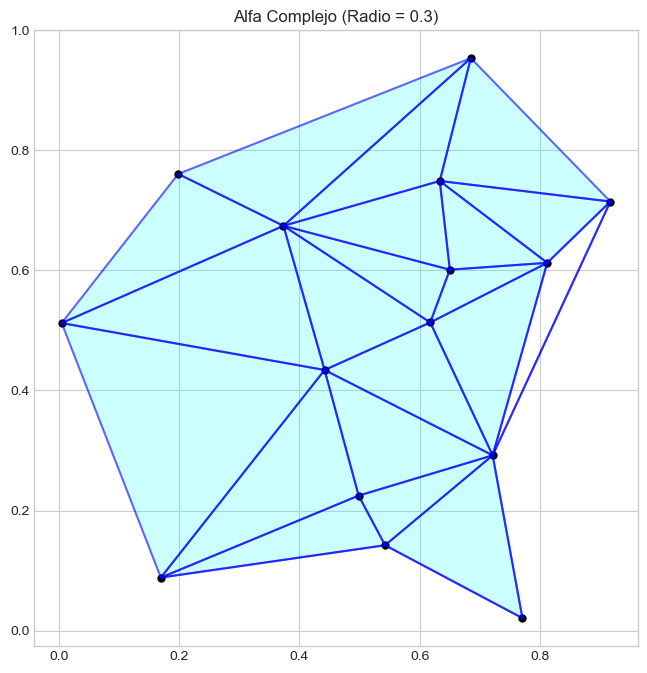

In [19]:
# ==============================================================================
# SECCIÓN 7: VISUALIZACIÓN GEOMÉTRICA (VORONOI Y ALFA)
# ==============================================================================

def plot_voronoi_diagram(points, title="Diagrama de Voronoi"):
    """
    Dibuja el Diagrama de Voronoi y la Triangulación de Delaunay (en gris suave).
    """
    vor = Voronoi(points)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    voronoi_plot_2d(
        vor, ax=ax, show_vertices=False, line_colors='orange', 
        line_width=2, line_alpha=0.8, point_size=2
    )
    
    ax.plot(points[:, 0], points[:, 1], 'ko', markersize=6, label='Puntos')
    
    tri = Delaunay(points)
    ax.triplot(points[:, 0], points[:, 1], tri.simplices, 'k--', alpha=0.1, label='Delaunay (Dual)')
    
    ax.set_title(title)
    ax.legend()
    margin = 0.5
    ax.set_xlim(np.min(points[:, 0]) - margin, np.max(points[:, 0]) + margin)
    ax.set_ylim(np.min(points[:, 1]) - margin, np.max(points[:, 1]) + margin)
    plt.axis('equal')
    plt.show()

def plot_alpha_complex_at_alpha(points, alpha, title=None):
    """
    Dibuja el Alfa Complejo para un valor concreto de alpha (radio).
    Muestra los triángulos y aristas de Delaunay que tienen radio < alpha.
    """
    tri = Delaunay(points)
    
    def get_radius(simp_indices):
        pts = points[list(simp_indices)]
        if len(pts) == 2:
            return np.linalg.norm(pts[0] - pts[1]) / 2.0
        elif len(pts) == 3:
            a, b, c = pts[0], pts[1], pts[2]
            la, lb, lc = np.linalg.norm(b - c), np.linalg.norm(a - c), np.linalg.norm(a - b)
            p = (la + lb + lc) / 2
            area_term = p * (p - la) * (p - lb) * (p - lc)
            area = np.sqrt(area_term) if area_term > 0 else 0
            return (la * lb * lc) / (4 * area) if area > 0 else float('inf')
        return 0.0

    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.plot(points[:, 0], points[:, 1], 'ko', markersize=5)
    
    for simplex in tri.simplices:
        if get_radius(simplex) <= alpha:
            pts = points[list(simplex)]
            ax.fill(pts[:, 0], pts[:, 1], 'cyan', alpha=0.2)
        for i in range(3):
            edge_idx = [simplex[i], simplex[(i + 1) % 3]]
            if get_radius(edge_idx) <= alpha:
                pts = points[edge_idx]
                ax.plot(pts[:, 0], pts[:, 1], 'b-', alpha=0.6)
    
    ax.set_title(title or f"Alfa Complejo (Radio = {alpha})")
    ax.set_aspect('equal')
    plt.show()

# --- EJECUCIÓN DE PRUEBA DE VISUALIZACIÓN ---
print("=== PRUEBA VISUAL: VORONOI Y ALFA ===")

np.random.seed(10)
random_points = np.random.rand(15, 2)

print("1. Generando Diagrama de Voronoi...")
plot_voronoi_diagram(random_points)

print("2. Generando Alfa Complejo (alpha=0.15 - Poca conectividad)...")
plot_alpha_complex_at_alpha(random_points, alpha=0.15)

print("3. Generando Alfa Complejo (alpha=0.3 - Aparecen ciclos)...")
plot_alpha_complex_at_alpha(random_points, alpha=0.3)
